In [6]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import soundfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


### Feature Extraction 

In [87]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate,hop_length=512,n_fft=2048).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=sample_rate, hop_length=512,n_fft=2048).T,axis=0) ###
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients



def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag



def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        # my added features
        #######
        y = waveform
        sr = sample_rate
        stft_=np.abs(librosa.stft(waveform))

        cent = np.mean( librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        contrast = np.mean( librosa.feature.spectral_contrast(S=stft_, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        #tonnetz = np.mean( librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sample_rate ,hop_length=512).T,axis=0)#
        rms = np.mean( librosa.feature.rms(y=y,frame_length=2048 ,hop_length=512).T, axis=0)
        spec_bw = np.mean( librosa.feature.spectral_bandwidth(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        rolloff = np.mean( librosa.feature.spectral_rolloff(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        zcr = np.mean( librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512).T, axis=0) 
        #######

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients , cent, contrast, rms, spec_bw, rolloff, zcr))
        
        return feature_matrix

In [88]:
#import os, glob

#def load_data():
#    X,y=[],[]
#    count = 0
#    for file in glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav'):
#        file_name=os.path.basename(file)
#        fileID = file.split('/')[-1]
#        features = get_features(file)
#        X.append(features)
       # y.append(emotion)
#        count += 1
        # '\r' + end='' results in printing over same line
#        print('\r' + f' Processed {count}/{20000} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
#    return np.array(X)

In [91]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #added 
            features = get_features(file)

            #xi = [power,pitch_mean,pitch_std,voiced_fr]

            xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,features))

            X.append(xi)
            y.append(label)
    return np.array(X),np.array(y)

In [90]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')


labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')


#X,y = getXy(files[:5000],labels_file=labels,scale_audio=True, onlySingleDigit=True)

a,b = getXy(files[:1000],labels_file=labels,scale_audio=True, onlySingleDigit=True)









  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=624
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=312
  n_fft, y.shape[-1]






  0%|          | 2/1000 [00:00<04:37,  3.59it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=678
  n_fft, y.shape[-1]






  0%|          | 4/1000 [00:01<05:22,  3.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=

KeyboardInterrupt: ignored

In [82]:
print('The shape of X is', a.shape) 
print('The shape of y is', b.shape)
#print('The labels vector is', y)

The shape of X is (310, 196)
The shape of y is (310,)


In [23]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
#print('The labels vector is', y)

NameError: ignored

### Best Feature Selection

In [73]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif#

#X.shape
#X_new = SelectKBest(mutual_info_classif, k=200).fit_transform(X, y)
X_new = SelectKBest(mutual_info_classif, k=150).fit_transform(a, b)

X_new.shape


(310, 150)

In [74]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 310
Numerical features extracted per sample: 150


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,187.723934,62.598813,0.291139,0.770630,0.802456,0.827890,0.779138,0.814540,0.774460,0.734193,0.782229,0.821627,0.762123,0.781257,14.515042,25.117332,7.487123,2.719220,2.415112,13.006311,6.930757,4.028258,1.122513,16.505573,31.761347,19.780783,17.342100,13.774872,37.632626,29.616724,20.804863,10.572713,108.069725,159.981689,44.133759,9.171792,14.270139,55.640800,5.734464,2.719491,...,8.339202e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-345.382385,82.239883,5.116749,-5.716528,1.056690,4.586895,1.685521,2.210224,2.286113,2.103068,2.422491,3.131922,0.121986,2.961297,1.832576,2.434273,3.909112,2.030295,1.435455,-0.696862,0.748781,2.655575,3.133205,1903.733078,13.342550,14.491569,14.183094,16.279184,16.970255,0.100528,2277.251051,4332.211304
1,130.283099,5.193614,0.241176,0.804258,0.761314,0.676881,0.703819,0.642448,0.629949,0.655282,0.637359,0.600166,0.663774,0.877174,0.000001,0.066930,0.000284,0.003845,0.257284,0.231254,0.006217,0.000756,0.034149,0.036772,0.003140,0.000582,0.004427,0.005828,0.000962,0.000829,0.043505,0.109088,0.061417,0.008087,0.019217,0.089656,0.051638,0.006181,0.006706,0.003790,...,2.912763e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-732.928467,50.041515,1.444669,3.036115,-6.599307,-1.856672,-1.418525,-0.535699,-0.478283,-1.734301,-2.577405,-1.184985,-4.630558,-0.775364,0.510881,1.911880,1.296045,2.152524,-0.376525,-1.353599,-0.589573,-0.842134,-1.351545,3690.346387,14.345018,19.123000,15.311646,16.080727,16.492509,0.003459,2967.029267,7202.983111
2,171.916609,26.854425,0.111888,0.771860,0.764209,0.689024,0.651190,0.629808,0.650154,0.639232,0.660599,0.789083,0.885277,0.825083,0.018878,0.389000,0.268590,0.508174,0.266551,0.174884,0.774053,0.515217,0.703575,1.385456,6.712080,13.318813,5.195361,4.526732,3.474549,1.465512,0.509539,0.498330,0.211244,0.040064,0.044417,0.051937,0.030221,0.029952,0.016025,0.007192,...,8.487560e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-440.412476,60.675266,10.593816,2.088058,2.977011,-0.191891,9.750838,5.366201,4.971224,0.946319,2.647785,5.649402,-0.723506,1.807690,0.359892,-1.577403,5.861119,-0.405031,3.262117,0.892276,2.338452,0.585328,0.290279,3290.033066,11.520795,14.424355,13.932368,17.836964,17.417378,0.020261,2474.796863,6001.483154
3,165.671895,28.076065,0.588785,0.488695,0.519082,0.551290,0.623619,0.725543,0.775133,0.703245,0.633878,0.652575,0.637664,0.543146,0.000011,20.612280,17.742716,1.093021,7.421634,6.091454,3.166740,2.248097,4.127024,0.626899,0.048198,0.019496,0.193911,0.119908,0.022272,0.008592,0.003658,0.002161,0.002264,0.003331,0.007083,0.004189,0.003720,0.007349,0.010528,0.003031,...,2.998500e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-439.554718,50.106136,6.835006,12.172791,-7.907770,-14.990190,-11.848413,-10.332999,-15.119155,-13.412454,-13.413696,-8.887530,-4.990288,-8.801100,-9.556822,-7.243377,-4.178809,-0.857305,-8.925093,1.399187,4.926601,5.827867,6.684693,1983.699413,16.178396,17.166961,16.582294,17.830107,17.432317,0.032884,2026.432981,4216.520182
4,105.684323,8.642074,0.275862,0.714868,0.709244,0.710227,0.666762,0.599184,0.573831,0.596318,0.657777,0.684871,0.721806,0.752549,0.001359,2.399819,10.552579,11.509242,3.962417,3.346293,15.373562,17.825766,12.162240,28.166241,47.770676,70.435829,80.743095,110.402229,139.483841,89.845802,83.996696,53.823792,14.485119,6.113783,3.721339,3.218826,1.716855,2.159767,2.374975,4.270342,...,2.736115e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-398.140656,88.005081,-6.232927,-20.226652,-13.593503,-17.604950,-7.984766,-7.490958,-6.648242,-5.038853,-1.586573,-4.659491,-4.273466,-6.345282,-3.573286,-4.491550,-1.516790,0.136003,-3.224302,0.966817,-0.774501,-1.292857,-0.453185,1743.764914,15.056230,19.179357,17.574343,18.789302,22.791555,0.111655,1844.980475,3656.931910
...,...,...,...,...,...,...,...,...,...,..

### Class Balance Check 

In [75]:
intonation_list = labels['intonation'].unique()
intonation_list

array(['question', 'excited', 'neutral', 'bored'], dtype=object)

NameError: ignored

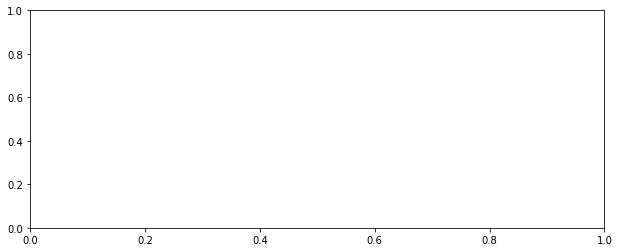

In [27]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(4), height=count)
plt.xticks(ticks=range(4), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('intonation')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [13]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


### Normalising

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_scaled = X
#features_scaled = a
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

#scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_minmax = features
#features_minmax = scaler.fit_transform(features_minmax)

In [77]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,0.175208,1.318015,-0.158520,1.005093,1.402286,1.588071,1.252868,1.635195,1.086224,0.600767,0.931387,1.265240,0.753637,1.007992,0.452356,3.656545,0.515569,-0.150344,-0.146983,0.578973,0.036036,-0.108786,-0.261983,1.214323,1.792899,0.877621,0.585977,0.863853,2.578920,1.165457,0.603178,0.153484,7.261624,9.938953,5.268596,0.880811,1.079716,6.802154,0.913457,0.825958,...,-0.007249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.280750,0.113587,0.362342,-0.627241,0.602020,1.211609,0.752389,0.951580,1.174822,0.901053,1.545527,1.160332,0.818433,1.520350,1.106093,1.140846,1.106857,1.030332,0.412698,0.090934,0.250009,1.342829,1.175287,-0.655508,-0.637271,-1.076073,-1.138064,-0.715316,-0.560581,2.521794,0.136945,-0.278700
1,-0.597050,-0.820414,-0.473621,1.338491,0.999251,0.155568,0.519515,-0.014733,-0.248657,-0.173565,-0.517389,-0.923944,-0.269654,1.982477,-0.060107,-0.352181,-0.440686,-0.421637,-0.319494,-0.290550,-0.251206,-0.298272,-0.318817,-0.404766,-0.288725,-0.317867,-0.269173,-0.307298,-0.281331,-0.201327,-0.172879,-0.110197,-0.188094,-0.171524,-0.250429,-0.245198,-0.233530,-0.249439,-0.210366,-0.305599,...,-0.057449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.481752,-0.956481,0.109905,0.094243,-0.352546,0.452366,0.261168,0.410728,0.588281,0.114959,0.354514,0.127049,-0.356435,0.509893,0.733686,0.996052,0.424473,1.066899,-0.044519,-0.099990,-0.245334,0.012668,-0.620729,1.772749,-0.206242,1.017999,-0.583954,-0.825440,-0.786262,-0.957496,1.990179,1.948882
2,-0.037312,-0.013517,-1.289005,1.017290,1.027619,0.270762,0.007097,-0.135916,-0.062025,-0.331056,-0.284975,0.943534,2.035016,1.453244,-0.059440,-0.300641,-0.406416,-0.371250,-0.318753,-0.294387,-0.219354,-0.274067,-0.283860,-0.272173,0.151019,0.487068,-0.013139,0.077235,-0.017316,-0.133731,-0.155458,-0.100388,-0.177760,-0.169503,-0.247276,-0.249875,-0.235508,-0.246426,-0.208537,-0.304182,...,-0.057415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.358147,-0.603083,0.738863,0.016095,0.841449,0.648527,2.028739,1.573198,1.744540,0.664091,1.599194,1.762909,0.609421,1.208395,0.691142,0.028907,1.616610,0.301763,0.873621,0.552922,0.838367,0.555524,0.036775,1.228667,-1.420567,-1.106463,-1.261168,0.149092,-0.349365,-0.355228,0.667693,1.016575
3,-0.121269,0.031991,1.718647,-1.790079,-1.373669,-1.035820,-0.261353,0.781947,1.092443,0.297079,-0.552202,-0.405878,-0.541323,-1.411142,-0.060106,2.935618,1.825461,-0.312818,0.253269,0.108320,-0.120102,-0.192539,-0.105088,-0.346749,-0.285772,-0.316723,-0.259827,-0.297595,-0.279712,-0.200968,-0.174368,-0.112891,-0.192174,-0.171824,-0.251947,-0.255794,-0.237956,-0.249291,-0.209616,-0.305916,...,-0.057448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366475,-0.954333,0.480464,0.847384,-0.515688,-1.095149,-1.389379,-1.518999,-2.518172,-2.277339,-2.226772,-1.716611,-0.445363,-1.660403,-2.103038,-1.541562,-1.005247,0.166458,-2.201583,0.700289,1.796276,2.549236,2.597559,-0.546823,0.582052,0.133588,0.039923,0.145288,-0.342307,0.097189,-0.536931,-0.368471
4,-0.927767,-0.691953,-0.254869,0.452261,0.489172,0.471893,0.158712,-0.429523,-0.767037,-0.752160,-0.313202,-0.086620,0.334153,0.716321,-0.060059,0.021143,0.907103,0.727865,-0.023282,-0.078527,0.386258,0.540358,0.314511,2.360712,2.842247,3.939140,3.713120,9.082668,10.320274,3.945050,2.965282,1.243399,0.806760,0.214362,0.212731,0.142758,-0.079728,0.023525,0.254304,1.472155,...,-0.057450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.768545,0.305186,-0.417891,-1.823317,-1.224597,-1.403245,-0.777950,-0.959216,-0.720841,-0.561986,0.590538,-0.704599,-0.268159,-0.996308,-0.417089,-0.778823,-0.310079,0.463623,-0.763100,0.574592,-0.313779,-0.158740,-0.260961,-0.872927,0.099557,1.043481,0.527011,0.677543,2.189336,2.920622,-1.024441,-0.802685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Dataset Spliting

In [78]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
#X_train, X_val, y_train, y_val = train_test_split(
#    X, 
#    y, 
#    test_size=0.2, 
#    stratify=y
#)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    b, 
    test_size=0.2, 
    stratify=b
)


## Comparing Models

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    b, 
    test_size=0.2, 
    stratify=b
)

classification_models = [
    KNeighborsClassifier(),#(3),
    #SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_val_scaled, y_val)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
1,SVC RBF kernel,48.39%
2,DecisionTreeClassifier,48.39%
3,RandomForestClassifier,48.39%
4,AdaBoostClassifier,48.39%
5,GaussianNB,35.48%
0,KNeighborsClassifier,29.03%
6,QuadraticDiscriminantAnalysis,29.03%


### GridSearchCV SVM

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


param_grid = { 'C':[1,2,3,4,5,6,7,8],'kernel':['rbf'],'gamma': [ 1, 0.1, 0.01 ]}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv= 5)
grid.fit(X_train_scaled,y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(grid.score(X_val_scaled, y_val)))

#grid_predictions = grid.predict(X_val)
#print(confusion_matrix(y_val,grid_predictions))
#print(classification_report(y_val,grid_predictions))#Output

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.3min finished


{'C': 8, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Test dataset accuracy of best hyperparameter setting: 0.6238532110091743.


### GridSearchCV RandomForestClassifier

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200,250,280,300,350],
    'max_features': ['sqrt']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train_scaled, y_train)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy (random forest classifier): {0}.'.format(grid.score(X_val_scaled, y_val)))

0.5779942090023691
{'max_features': 'sqrt', 'n_estimators': 350}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)
Test dataset accuracy (random forest classifier): 0.617737003058104.
